# CIS 5200: Machine Learning
## Homework 1

In [34]:
import os
import sys

# For autograder only, do not modify this cell. 
# True for Google Colab, False for autograder
NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")
    sys.exit()

[INFO, OK] Google Colab.


### Penngrader setup

In [35]:
# %%capture
!pip install penngrader-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
%%writefile config.yaml
grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Overwriting config.yaml


In [37]:
from penngrader.grader import PennGrader

# PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO 
# TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 38513713 # YOUR PENN-ID GOES HERE AS AN INTEGER #
SECRET = STUDENT_ID

grader = PennGrader('config.yaml', 'CIS5200_23Sp_HW1', STUDENT_ID, SECRET)

PennGrader initialized with Student ID: 38513713

Make sure this correct or we will not be able to store your grade


# Dataset: Wine Quality Prediction

Some research on blind wine tasting has suggested that [people cannot taste the difference between ordinary and pricy wine brands](https://phys.org/news/2011-04-expensive-inexpensive-wines.html). Indeed, even experienced tasters may be as consistent as [random numbers](https://www.seattleweekly.com/food/wine-snob-scandal/). Is professional wine tasting in shambles? Maybe ML can take over. 

In this problem set, we will train some simple linear models to predict wine quality. We'll be using the data from [this repository](https://archive.ics.uci.edu/ml/datasets/Wine+Quality) for both the classification and regression tasks. The following cells will download and set up the data for you. 

In [38]:
%%capture
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality.names

In [39]:
from sklearn.model_selection import train_test_split
import pandas as pd
import torch

red_df = pd.read_csv('winequality-red.csv', delimiter=';')

X = torch.from_numpy(red_df.drop(columns=['quality']).to_numpy())
y = torch.from_numpy(red_df['quality'].to_numpy())

# Split data into train/test splits 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42) 

# Normalize the data to have zero mean and standard deviation, 
# and add bias term
mu, sigma = X_train.mean(0), X_train.std(0) 
X_train, X_test = [ torch.cat([((x-mu)/sigma).float(), torch.ones(x.size(0),1)], dim=1) 
                    for x in [X_train, X_test]]

# Transform labels to {-1,1} for logistic regression
y_binary_train, y_binary_test = [ (torch.sign(y - 5.5)).long() 
                                  for y in [y_train, y_test]]
y_regression_train, y_regression_test = [ y.float() for y in [y_train, y_test]]

# 1. Logistic Regression

In this first problem, you will implement a logistic regression classifier to classify good wine (`y=1`) from bad wine (`y=-1`). Your professor has arbitrarily decided that good wine has a score of at least 5.5. The classifier is split into the following components: 

1. Loss (3pts) & gradient (3pts) - given a batch of examples $X$ and labels $y$ and weights for the logistic regression classifier, compute the batched logistic loss and gradient of the loss with *with respect to the model parameters $w$*. Note that this is slightly different from the gradient in Homework 0, which was with respect to the sample $X$. 
2. Fit (2pt) - Given a loss function and data, find the weights of an optimal logistic regression model that minimizes the logistic loss
3. Predict (3pts) - Given the weights of a logistic regression model and new data, predict the most likely class

We provide an generic gradient-based optimizer for you which minimizes the logistic loss function, you can call it with `LogisticOptimizer().optimize(X,y)`. It does not need any parameter adjustment. 

Hint: The optimizer will minimize the logistic loss. So this value of this loss should be decreasing over iterations.

In [40]:
class LogisticOptimizer: 
    @staticmethod
    def logistic_loss(X, y, w): 
        # Given a batch of samples and labels, and the weights of a logistic 
        # classifier, compute the batched logistic loss. 
        # 
        # X := Tensor(float) of size (m,d) --- This is a batch of m examples of 
        #     of dimension d
        # 
        # y := Tensor(int) of size (m,) --- This is a batch of m labels in {-1,1}
        # 
        # w := Tensor(float) of size(d,) --- This is the weights of a logistic 
        #     classifer. 
        # 
        # Return := Tensor of size (m,) --- This is the logistic loss for each 
        #     example. 

        # Fill in the rest
        # log 1 + exp(−y w⊤x)
        y = y.float()
        fx = torch.sigmoid(w.unsqueeze(1).T@X.T)
        ret = torch.where(y == 1, -torch.log(fx), -torch.log(1 - fx))
        return ret.squeeze(0)

    @staticmethod
    def logistic_gradient(X, y, w): 
        # Given a batch of samples and labels, compute the batched gradient of
        # the logistic loss. 
        # 
        # X := Tensor(float) of size (m,d) --- This is a batch of m examples of 
        #     of dimension d
        # 
        # y := Tensor(int) of size (m,) --- This is a batch of m labels in {-1,1}
        # 
        # w := Tensor(float) of size(d,) --- This is the weights of a logistic 
        #     classifer. 
        # 
        # Return := Tensor of size (m,d) --- This is the logistic gradient for each 
        #     example. 
        # 
        # Hint: A very similar gradient was calculated in Homework 0. 
        # However, that was the sample gradient (with respect to X), whereas 
        # what we need here is the parameter gradient (with respect to w). 
    
        # Fill in the rest
        ywx = y*X.matmul(w)
        return X * (-y*torch.exp(-ywx)/(1 + torch.exp(-ywx))).unsqueeze(1)

    def optimize(self, X, y, niters=100): 
        # Given a dataset of examples and labels, minimizes the logistic loss 
        # using standard gradient descent. 
        # 
        # This optimizer is written for you, and you only need to implement the 
        # logistic loss and gradient functions above. 
        # 
        # X := Tensor(float) of size (m,d) --- This is a batch of m examples of 
        #     of dimension d
        # 
        # y := Tensor(int) of size (m,) --- This is a batch of m labels in {-1,1}
        # 
        # Return := Tensor of size(d,) --- This is the fitted weights of a 
        #     logistic regression model 

        m,d = X.size()
        w = torch.zeros(d)
        print('Optimizing logistic function...')
        for i in range(niters): 
            loss = self.logistic_loss(X,y,w).mean()
            grad = self.logistic_gradient(X,y,w).mean(0)
            w -= grad
            if i % 50 == 0: 
                print(i, loss.item())
        print('Optimizing done.')
        return w

def logistic_fit(X, y, optimizer=LogisticOptimizer): 
    # Given a dataset of examples and labels, fit the weights of the logistic 
    # regression classifier using the provided loss function and optimizer
    # 
    # X := Tensor(float) of size (m,d) --- This is a batch of m examples of 
    #     of dimension d
    # 
    # y := Tensor(int) of size (m,) --- This is a batch of m labels in {-1,1}
    # 
    # Return := Tensor of size (d,) --- This is the fitted weights of the 
    #     logistic regression model 
    opt = LogisticOptimizer()

    # Fill in the rest
    return LogisticOptimizer.optimize(opt, X, y)

def logistic_predict(X, w):
    # Given a dataset of examples and fitted weights for a logistic regression 
    # classifier, predict the class
    # 
    # X := Tensor(float) of size(m,d) --- This is a batch of m examples of 
    #    dimension d
    # 
    # w := Tensor(float) of size (d,) --- This is the fitted weights of the 
    #    logistic regression model
    # 
    # Return := Tensor of size (m,) --- This is the predicted classes {-1,1}
    #    for each example
    #
    # Hint: Remember that logistic regression expects a label in {-1,1}, and 
    # not {0,1} 

    # Fill in the rest
    return torch.sign(X.matmul(w))
    


In [41]:
# Test your code on the wine dataset! 
# How does your solution compare to a random linear classifier? 
# Your solution should get around 75% accuracy on the test set. 
torch.manual_seed(42)

d = X_train.size(1)
logistic_weights = {
    'zero': torch.zeros(d), 
    'random': torch.randn(d),
    'fitted': logistic_fit(X_train, y_binary_train)
}

for k,w in logistic_weights.items(): 
    yp_binary_train = logistic_predict(X_train, w)
    acc_train = (yp_binary_train == y_binary_train).float().mean()

    print(f'Train accuracy [{k}]: {acc_train.item():.2f}')

    yp_binary_test = logistic_predict(X_test, w)
    acc_test = (yp_binary_test == y_binary_test).float().mean()

    print(f'Test accuracy [{k}]: {acc_test.item():.2f}')

Optimizing logistic function...
0 0.6931473016738892
50 0.518214225769043
Optimizing done.
Train accuracy [zero]: 0.00
Test accuracy [zero]: 0.00
Train accuracy [random]: 0.54
Test accuracy [random]: 0.53
Train accuracy [fitted]: 0.75
Test accuracy [fitted]: 0.75


### Autograder
Be sure you can pass the following four tests! 

In [42]:
grader.grade(test_case_id = 'logistic_loss', answer = LogisticOptimizer.logistic_loss)
grader.grade(test_case_id = 'logistic_gradient', answer = LogisticOptimizer.logistic_gradient)
grader.grade(test_case_id = 'logistic_fit', answer = logistic_fit)
grader.grade(test_case_id = 'logistic_predict', answer = logistic_predict)

You earned 2/3 points.

But, don't worry you can re-submit and we will keep only your latest score.
Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# 2. Linear Regression with Ridge Regression

In this second problem, you'll implement a linear regression model. Similarly to the first problem, implement the following functions: 

1. Loss (3pts) - Given a batch of examples $X$ and labels $y$, compute the batched mean squared error loss for a linear model with weights $w$. 
2. Fit (4pts) - Given a batch of examples $X$ and labels $y$, find the weights of the optimal linear regression model
3. Predict (3pts) - Given the weights $w$ of a linear regression model and new data $X$, predict the most likely label

This time, you are not given an optimizer for the fitting function since this problem has an analytic solution. Make sure to test your solution with non-zero ridge regression parameters. 

Hint: You may want to review ridge regression on Slide 22 of Lecture 3. 

In [43]:
def regression_loss(X, y, w): 
    # Given a batch of linear regression outputs and true labels, compute 
    # the batch of squared error losses. This is *without* the ridge 
    # regression penalty. 
    # 
    # X := Tensor(float) of size (m,d) --- This is a batch of m examples of 
    #     of dimension d
    # 
    # y := Tensor(int) of size (m,) --- This is a batch of m real-valued labels
    # 
    # w := Tensor(float) of size(d,) --- This is the weights of a linear 
    #     classifer
    # 
    # Return := Tensor of size (m,) --- This is the squared loss for each 
    #     example

    # Fill in the rest
    y_pred = w@X.T
    return (y-y_pred)**2

def regression_fit(X, y, ridge_penalty=1.0): 
    # Given a dataset of examples and labels, fit the weights of the linear 
    # regression classifier using the provided loss function and optimizer
    # 
    # X := Tensor(float) of size (m,d) --- This is a batch of m examples of 
    #     of dimension d
    # 
    # y := Tensor(float) of size (m,) --- This is a batch of m real-valued 
    #     labels
    #
    # ridge_penalty := float --- This is the parameter for ridge regression
    # 
    # Return := Tensor of size (d,) --- This is the fitted weights of the 
    #     linear regression model 
    # 
    # Fill in the rest
    # wˆλ = (X⊤X + λmI)−1X⊤Y.
    m = X.size(0)
    inv = torch.linalg.inv(X@X.T + ridge_penalty * m * torch.eye(m))
    return torch.t(inv@X)@y

def regression_predict(X, w):
    # Given a dataset of examples and fitted weights for a linear regression 
    # classifier, predict the label
    # 
    # X := Tensor(float) of size(m,d) --- This is a batch of m examples of 
    #    dimension d
    # 
    # w := Tensor(float) of size (d,) --- This is the fitted weights of the 
    #    linear regression model
    # 
    # Return := Tensor of size (m,) --- This is the predicted real-valued labels
    #    for each example
    # 
    # Fill in the rest
    return w@X.T

In [44]:
# Test your code on the wine dataset! 
# How does your solution compare to a random linear classifier? 
# Your solution should get an average squard error of about 8.6 test set. 
torch.manual_seed(42)

d = X_train.size(1)
regression_weights = {
    'zero': torch.zeros(d), 
    'random': torch.randn(d),
    'fitted': regression_fit(X_train, y_regression_train)
}

for k,w in regression_weights.items(): 
    yp_regression_train = regression_predict(X_train, w)
    squared_loss_train = regression_loss(X_train, y_regression_train, w).mean()

    print(f'Train accuracy [{k}]: {squared_loss_train.item():.2f}')

    yp_regression_test = regression_predict(X_test, w)
    squared_loss_test = regression_loss(X_test, y_regression_test, w).mean()

    print(f'Test accuracy [{k}]: {squared_loss_test.item():.2f}')

Train accuracy [zero]: 32.28
Test accuracy [zero]: 32.97
Train accuracy [random]: 29.64
Test accuracy [random]: 29.55
Train accuracy [fitted]: 8.37
Test accuracy [fitted]: 8.60


### Autograder
Check the following 3 test cases. 

In [45]:
grader.grade(test_case_id = 'regression_loss', answer = regression_loss)
grader.grade(test_case_id = 'regression_fit', answer = regression_fit)
grader.grade(test_case_id = 'regression_predict', answer = regression_predict)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# 3. Perceptron

In this last problem, you will implement the perceptron algorithm. Since the algorithm requires linearly separate data and real data is usually noisy, we will have to use a synthetic example. 

In [46]:
# Data generation for perceptron problem
torch.manual_seed(42)

m,d = 10,2
X_perceptron = torch.randn(m,d) # generate random data
w_opt = torch.randn(d) # generate random optimal solution
y_perceptron = torch.sign(X_perceptron.matmul(w_opt)) # generate solution-consistent labels

We've given you a template for the perceptron algorithm. Calculate the following remaining functions: 

1. (3pts) Calculate the theoretical margin given the optimal linear classifier 
2. (3pts) Compute the condition for when the perceptron algorithm makes an update on a specific example
3. (3pts) Compute the perceptron algorithm update to the weights when the update condition is satisfied

You do not need to change `perceptron_algorithm`. 

In [47]:
def perceptron_margin(X, w_opt): 
    # X := Tensor(float) of size (m,d) --- This is a batch of m examples of 
    #     of dimension d
    # 
    # w_opt := Tensor(float) of size (d,) --- This is the ground truth linear 
    #     weights 
    # 
    # Return := Tensor(float) of size (1,) --- This is the theoretical margin
    # 
    # Fill in the rest
    w = torch.nn.functional.normalize(w_opt.unsqueeze(0), p=2, dim=1)
    ret = torch.min(torch.abs(w@X.T))
    print(ret.squeeze(0))
    return ret.squeeze(0)

def perceptron_update_condition(xi, yi, w): 
    # xi := Tensor(float) of size (d,) --- This is a a single example of 
    #     of dimension d
    # 
    # yi := Tensor(float) of size (1,) --- This is a single label for the 
    #     example xi
    # 
    # w := Tensor(float) of size (d,) --- This is the current estimate of the  
    #     linear weights 
    # 
    # Return := Tensor(bool) of size (1,) --- This is true if the perceptron 
    #     algorithim will do an update on this example, and false otherwise
    # 
    # Fill in the rest
    yi_pred_sign = torch.sign(w@xi)
    return torch.where(yi_pred_sign != torch.sign(yi), True, False)

def perceptron_update_weight(xi, yi, w): 
    # xi := Tensor(float) of size (d,) --- This is a a single example of 
    #     of dimension d
    # 
    # yi := Tensor(float) of size (1,) --- This is a single label for the 
    #     example xi
    # 
    # w := Tensor(float) of size (d,) --- This is the current estimate of the  
    #     linear weights 
    # 
    # Return := Tensor(float) of size (d,) --- This is the updated linear  
    #     weights after performing the perceptron update
    # 
    # Fill in the rest
    # w = torch.nn.functional.normalize(w.unsqueeze(0), p=2, dim=1)
    yixi = yi.float().unsqueeze(0)@xi.float().unsqueeze(0)
    ret = torch.add(w.float(), yixi.squeeze(0))
    return ret.squeeze(0)

def perceptron_algorithm(X, y, niters=100):
    m,d = X.size()
    w = torch.zeros(d)
    for t in range(niters):
        weight_updated = False
        for xi,yi in zip(X,y): 
            if perceptron_update_condition(xi, yi, w): 
                w = perceptron_update_weight(xi, yi, w)
                weight_updated = True
                break
        if not weight_updated: 
            return w,t

Try running the perceptron algorithm. Does it terminate in fewer steps than the theoretical bound? Is the final classifier close to the ground truth? 

Accuracy: 1.00 in 1 rounds.
tensor(0.1362)
Margin: 0.14. The perceptron algorithm is guaranteed to terminate in 53.92 rounds.


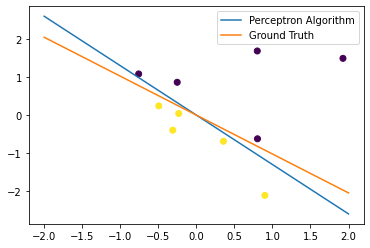

In [48]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Test this out on the synthetic data
w_perceptron,t = perceptron_algorithm(X_perceptron,y_perceptron)
acc_perceptron = (torch.sign(X_perceptron.matmul(w_perceptron)) == y_perceptron).float().mean()

print(f"Accuracy: {acc_perceptron:.2f} in {t} rounds.")

margin = perceptron_margin(X_perceptron,w_opt)
print(f"Margin: {margin:.2f}. The perceptron algorithm is guaranteed to terminate in {1/(margin**2):.2f} rounds.")

# Plot the classifier. Is it close to the the ground truth? 
plt.scatter(X_perceptron[:,0], X_perceptron[:,1], c=y_perceptron)
X_range = torch.linspace(-2,2, 50)
plt.plot(X_range, -w_perceptron[0]/w_perceptron[1]*X_range) # estimated
plt.plot(X_range, -w_opt[0]/w_opt[1]*X_range) # optimal
plt.legend(['Perceptron Algorithm', 'Ground Truth'])

### Autograder
Check the following 3 test cases. 

In [49]:
grader.grade(test_case_id = 'perceptron_margin', answer = perceptron_margin)
grader.grade(test_case_id = 'perceptron_update_condition', answer = perceptron_update_condition)
grader.grade(test_case_id = 'perceptron_update_weight', answer = perceptron_update_weight)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Submitting to Gradescope
Before submitting to Gradescope, make sure that selecting "Runtime" -> "Restart and run all" completes all cells without errors. 

1. Go to the File menu and choose "Download .ipynb" and also "Download .py". Make sure these files are named homework1.ipynb and homework1.py, respectively
2. Go to GradeScope through the canvas page and ensure your class is "BAN_CIS-5200-001 202310"
3. Select Homework 1
4. Upload both files (the .ipynb and the .py)
5. PLEASE CHECK THE AUTOGRADER OUTPUT TO ENSURE YOUR SUBMISSION IS PROCESSED CORRECTLY! If this is the case, you should be all set with the programming component of this homework!